In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishi671","key":"ea91b6c482d1e1c2d058e1da9b105eed"}'}

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:06<00:00, 50.4MB/s]
100% 812M/812M [00:06<00:00, 123MB/s] 


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Since the model may overfit, we employ the regularization approach during the DATA PREPROCESSING step. Here, every image is transformed into a tensor.

In [ ]:

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Callback can be used to terminate training early if the model is not progressing, or to store the model's weights at the end of each epoch. Callbacks may also be used to schedule changes in learning rate, log metrics, and display the model's performance.


In [ ]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.x",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 19s 105ms/step - loss: 0.7062 - accuracy: 0.5165 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 5s 75ms/step - loss: 0.6935 - accuracy: 0.5300 - val_loss: 0.6893 - val_accuracy: 0.5780
Epoch 3/10
63/63 [==============================] - 5s 84ms/step - loss: 0.6968 - accuracy: 0.5385 - val_loss: 0.6682 - val_accuracy: 0.6080
Epoch 4/10
63/63 [==============================] - 4s 58ms/step - loss: 0.6883 - accuracy: 0.5615 - val_loss: 0.7522 - val_accuracy: 0.5090
Epoch 5/10
63/63 [==============================] - 6s 91ms/step - loss: 0.6616 - accuracy: 0.6265 - val_loss: 0.6420 - val_accuracy: 0.6220
Epoch 6/10
63/63 [==============================] - 6s 86ms/step - loss: 0.6254 - accuracy: 0.6555 - val_loss: 0.6180 - val_accuracy: 0.6440
Epoch 7/10
63/63 [==============================] - 5s 74ms/step - loss: 0.5977 - accuracy: 0.6775 - val_loss: 0.6099 - val_accuracy: 0.6690
Epoch 8/10


It can be observed that as the number of epochs increases, accuracy is seen to increase

Accuracy=74.2% Val_acc=69.5% test accuracy=70.4%

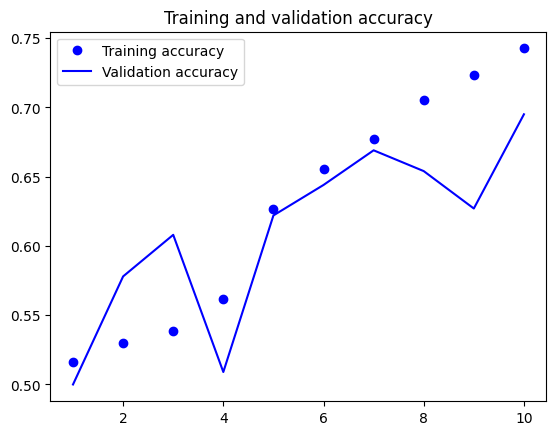

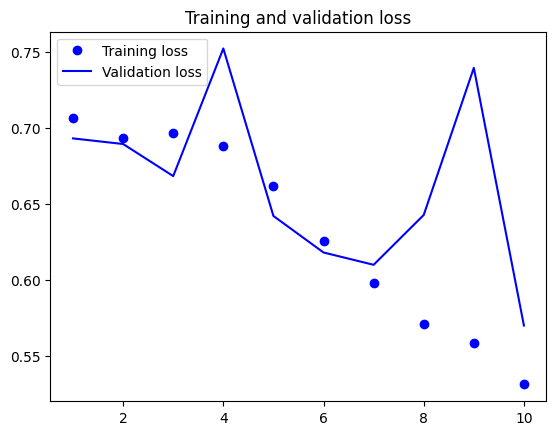

In [ ]:

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:

test_model = keras.models.load_model("convnet_from_scratch1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.6104 - accuracy: 0.7040
Test accuracy: 0.704


Test accuracy with no data augmentation=70.4%

**Data Augmentation**

Data augmentation is a technique used to increase the size of a training set by creating new, modified versions of the original data. This helps to reduce overfitting and improve the generalization ability of the model.

In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 8s 89ms/step - loss: 0.7060 - accuracy: 0.5095 - val_loss: 0.6917 - val_accuracy: 0.5930
Epoch 2/10
63/63 [==============================] - 8s 110ms/step - loss: 0.6927 - accuracy: 0.5150 - val_loss: 0.6885 - val_accuracy: 0.5070
Epoch 3/10
63/63 [==============================] - 6s 91ms/step - loss: 0.6870 - accuracy: 0.5670 - val_loss: 0.6790 - val_accuracy: 0.6240
Epoch 4/10
63/63 [==============================] - 5s 69ms/step - loss: 0.6586 - accuracy: 0.6175 - val_loss: 0.9330 - val_accuracy: 0.5280
Epoch 5/10
63/63 [==============================] - 6s 86ms/step - loss: 0.6586 - accuracy: 0.6420 - val_loss: 0.6077 - val_accuracy: 0.6610
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6317 - accuracy: 0.6535 - val_loss: 0.6158 - val_accuracy: 0.6700
Epoch 7/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6164 - accuracy: 0.6710 - val_loss: 0.6125 - val_accuracy: 0.6440
Epoch 8/10
6

Although doing data augmentation on the model did not result in improved results, it is still possible to verify this by trying data augmentation on a larger training sample.

accuracy=69.6% val_acc=66.00% test_acc=68.6%

In [ ]:

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.6219 - accuracy: 0.6860
Test accuracy: 0.686


Test accuracy was not improved

**2)Increase training sample size**

Attempted to increase training sample size from 1000 to 1500.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 11s 92ms/step - loss: 0.6984 - accuracy: 0.5087 - val_loss: 0.6905 - val_accuracy: 0.5130
Epoch 2/10
94/94 [==============================] - 6s 65ms/step - loss: 0.6879 - accuracy: 0.5597 - val_loss: 0.6739 - val_accuracy: 0.5770
Epoch 3/10
94/94 [==============================] - 7s 77ms/step - loss: 0.6486 - accuracy: 0.6380 - val_loss: 0.6150 - val_accuracy: 0.6620
Epoch 4/10
94/94 [==============================] - 6s 64ms/step - loss: 0.5980 - accuracy: 0.6807 - val_loss: 0.6014 - val_accuracy: 0.6860
Epoch 5/10
94/94 [==============================] - 11s 111ms/step - loss: 0.5594 - accuracy: 0.7140 - val_loss: 0.5660 - val_accuracy: 0.7000
Epoch 6/10
94/94 [==============================] - 7s 77ms/step - loss: 0.5168 - accuracy: 0.7397 - val_loss: 0.6430 - val_accuracy: 0.6550
Epoch 7/10
94/94 [==============================] - 6s 65ms/step - loss: 0.4897 - accuracy: 0.7630 - val_loss: 0.5378 - val_accuracy: 0.7220
Epoch 8/10

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.5090 - accuracy: 0.7650
Test accuracy: 0.765


Accuracy=84.0% val_acc=74.3% test_acc=76.5%

**Using data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
94/94 [==============================] - 12s 90ms/step - loss: 0.6919 - accuracy: 0.5240 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/10
94/94 [==============================] - 7s 75ms/step - loss: 0.6923 - accuracy: 0.5297 - val_loss: 0.6931 - val_accuracy: 0.5080
Epoch 3/10
94/94 [==============================] - 7s 75ms/step - loss: 0.6894 - accuracy: 0.5207 - val_loss: 0.6924 - val_accuracy: 0.5070
Epoch 4/10
94/94 [==============================] - 8s 86ms/step - loss: 0.6900 - accuracy: 0.5210 - val_loss: 0.6898 - val_accuracy: 0.5470
Epoch 5/10
94/94 [==============================] - 8s 87ms/step - loss: 0.6843 - accuracy: 0.5630 - val_loss: 0.6731 - val_accuracy: 0.6040
Epoch 6/10
94/94 [==============================] - 11s 118ms/step - loss: 0.6595 - accuracy: 0.6210 - val_loss: 0.6693 - val_accuracy: 0.5990
Epoch 7/10
94/94 [==============================] - 9s 89ms/step - loss: 0.6427 - accuracy: 0.6343 - val_loss: 0.6321 - val_accuracy: 0.6410
Epoch 8/10

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.5567 - accuracy: 0.7100
Test accuracy: 0.710


Accuracy=71.2% val_acc=69.5% test_acc=71.0%

**3. Finding the ideal training sample size**

We set the training, validation, and test set sizes, respectively, to 1500, 1000, and 500.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 9s 76ms/step - loss: 0.6973 - accuracy: 0.4823 - val_loss: 0.6921 - val_accuracy: 0.5210
Epoch 2/10
94/94 [==============================] - 8s 87ms/step - loss: 0.6928 - accuracy: 0.5470 - val_loss: 0.6750 - val_accuracy: 0.6350
Epoch 3/10
94/94 [==============================] - 8s 88ms/step - loss: 0.6521 - accuracy: 0.6320 - val_loss: 0.6786 - val_accuracy: 0.5965
Epoch 4/10
94/94 [==============================] - 8s 84ms/step - loss: 0.6058 - accuracy: 0.6683 - val_loss: 0.6200 - val_accuracy: 0.6685
Epoch 5/10
94/94 [==============================] - 8s 81ms/step - loss: 0.5631 - accuracy: 0.7183 - val_loss: 0.8181 - val_accuracy: 0.6325
Epoch 6/10
94/94 [==============================] - 7s 72ms/step - loss: 0.5243 - accuracy: 0.7457 - val_loss: 0.6589 - val_accuracy: 0.6650
Epoch 7/10
94/94 [==============================] - 8s 80ms/step - loss: 0.4882 - accuracy: 0.7643 - val_loss: 0.5535 - val_accuracy: 0.7130
Epoch 8/10
94

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 52ms/step - loss: 0.5620 - accuracy: 0.6870
Test accuracy: 0.687


Accuracy=83.7% val_Acc=66.2% test_Acc=68.7%

**Using Data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 12s 88ms/step - loss: 0.6981 - accuracy: 0.5027 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/10
94/94 [==============================] - 10s 101ms/step - loss: 0.6891 - accuracy: 0.5297 - val_loss: 0.6881 - val_accuracy: 0.5000
Epoch 3/10
94/94 [==============================] - 8s 81ms/step - loss: 0.6935 - accuracy: 0.5083 - val_loss: 0.6920 - val_accuracy: 0.5530
Epoch 4/10
94/94 [==============================] - 9s 91ms/step - loss: 0.6885 - accuracy: 0.5073 - val_loss: 0.6858 - val_accuracy: 0.5310
Epoch 5/10
94/94 [==============================] - 10s 102ms/step - loss: 0.6760 - accuracy: 0.5820 - val_loss: 0.6855 - val_accuracy: 0.6140
Epoch 6/10
94/94 [==============================] - 13s 132ms/step - loss: 0.6590 - accuracy: 0.6087 - val_loss: 0.6555 - val_accuracy: 0.6165
Epoch 7/10
94/94 [==============================] - 9s 90ms/step - loss: 0.6544 - accuracy: 0.6150 - val_loss: 0.6444 - val_accuracy: 0.6500
Epoch 

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.6262 - accuracy: 0.6760
Test accuracy: 0.676


Accuracy=66.9% val_acc=63.9% test_acc=67.6%

**4.Using a pre-trained network**

VGG16 is the architecture of this pre-trained network.

Feature extraction - Instantiating the VGG16 convolutional base

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

Feature extraction - Extracting features and corresponding labels

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 [==============================] - 1s 1s/step


(3000, 5, 5, 512)

Feature extraction - Defining and training the densely connected classifier

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 3s 19ms/step - loss: 14.7227 - accuracy: 0.9323 - val_loss: 24.8477 - val_accuracy: 0.8855
Epoch 2/15
94/94 [==============================] - 1s 13ms/step - loss: 3.2240 - accuracy: 0.9790 - val_loss: 5.4003 - val_accuracy: 0.9725
Epoch 3/15
94/94 [==============================] - 1s 15ms/step - loss: 1.6405 - accuracy: 0.9897 - val_loss: 4.7675 - val_accuracy: 0.9755
Epoch 4/15
94/94 [==============================] - 1s 9ms/step - loss: 1.2323 - accuracy: 0.9900 - val_loss: 6.6152 - val_accuracy: 0.9710
Epoch 5/15
94/94 [==============================] - 1s 9ms/step - loss: 0.8997 - accuracy: 0.9930 - val_loss: 4.8369 - val_accuracy: 0.9760
Epoch 6/15
94/94 [==============================] - 1s 11ms/step - loss: 0.5726 - accuracy: 0.9960 - val_loss: 4.3433 - val_accuracy: 0.9755
Epoch 7/15
94/94 [==============================] - 1s 8ms/step - loss: 0.5889 - accuracy: 0.9953 - val_loss: 5.1415 - val_accuracy: 0.9755
Epoch 8/15
94/

accuracy=99.8% val_acc=97.8%

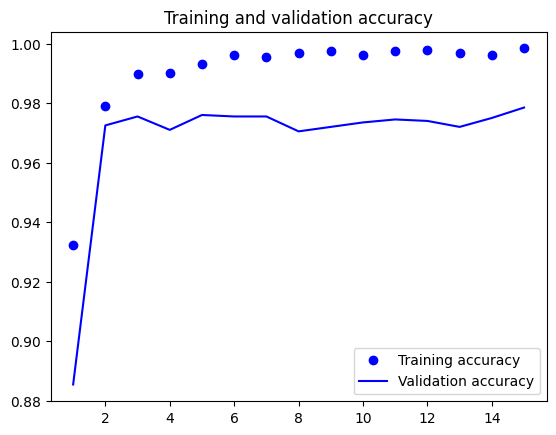

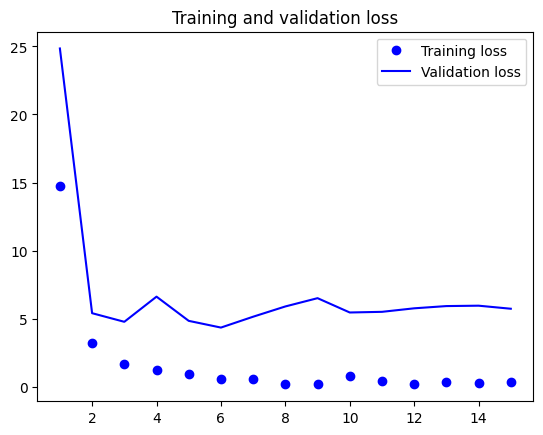

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Feature extraction with Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
94/94 [==============================] - 20s 193ms/step - loss: 16.1840 - accuracy: 0.9087 - val_loss: 5.5871 - val_accuracy: 0.9620
Epoch 2/5
94/94 [==============================] - 18s 190ms/step - loss: 7.2862 - accuracy: 0.9480 - val_loss: 4.7601 - val_accuracy: 0.9730
Epoch 3/5
94/94 [==============================] - 18s 187ms/step - loss: 4.8308 - accuracy: 0.9613 - val_loss: 3.5003 - val_accuracy: 0.9775
Epoch 4/5
94/94 [==============================] - 22s 237ms/step - loss: 5.1065 - accuracy: 0.9623 - val_loss: 3.0577 - val_accuracy: 0.9775
Epoch 5/5
94/94 [==============================] - 15s 156ms/step - loss: 4.5839 - accuracy: 0.9623 - val_loss: 3.5981 - val_accuracy: 0.9745


In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 90ms/step - loss: 4.0563 - accuracy: 0.9710
Test accuracy: 0.971


Accuracy=96.2% val_Acc=97.4% test_acc=97.1%

